In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [174]:
import datetime
import scipy.stats as stats
from datetime import datetime

In [4]:
path = '../input/g-research-crypto-forecasting/'

In [5]:
!ls {path}

asset_details.csv	       example_test.csv  supplemental_train.csv
example_sample_submission.csv  gresearch_crypto  train.csv


### Dimensions of the datasets

Let's start loading datasets and explore the dimensions !

In [6]:
df_train = pd.read_csv(path+"train.csv")

In [7]:
print(df_train.shape)
df_train.head()

(24236806, 10)


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


The meanings of the features included in the set are the following:
* timestamp: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
* Asset_ID: The asset ID corresponding to one of the crytocurrencies (e.g. Asset_ID = 1 for Bitcoin). The mapping from Asset_ID to crypto asset is contained in asset_details.csv.
* Count: Total number of trades in the time interval (last minute).
* Open: Opening price of the time interval (in USD).
* High: Highest price reached during time interval (in USD).
* Low: Lowest price reached during time interval (in USD).
* Close: Closing price of the time interval (in USD).
* Volume: Quantity of asset bought or sold, displayed in base currency USD.
* VWAP: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
* Target: Residual log-returns for the asset over a 15 minute horizon.

In [8]:
df_asset_details = pd.read_csv(path+"asset_details.csv")

In [9]:
print(df_asset_details.shape)
print(df_asset_details.sort_values("Asset_ID"))

(14, 3)
    Asset_ID    Weight        Asset_Name
1          0  4.304065      Binance Coin
2          1  6.779922           Bitcoin
0          2  2.397895      Bitcoin Cash
10         3  4.406719           Cardano
13         4  3.555348          Dogecoin
3          5  1.386294            EOS.IO
5          6  5.894403          Ethereum
4          7  2.079442  Ethereum Classic
11         8  1.098612              IOTA
6          9  2.397895          Litecoin
12        10  1.098612             Maker
7         11  1.609438            Monero
9         12  2.079442           Stellar
8         13  1.791759              TRON


In [10]:
assets = df_asset_details['Asset_Name'].tolist()

In [11]:
print(assets)

['Bitcoin Cash', 'Binance Coin', 'Bitcoin', 'EOS.IO', 'Ethereum Classic', 'Ethereum', 'Litecoin', 'Monero', 'TRON', 'Stellar', 'Cardano', 'IOTA', 'Maker', 'Dogecoin']


In [12]:
df_supp_train = pd.read_csv(path+"supplemental_train.csv")
print(df_supp_train.shape)
df_supp_train.head()

(2015112, 10)


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1623542400,3,1201.0,1.478556,1.48603,1.47800,1.483681,654799.561103,1.481439,-0.002594
1,1623542400,2,1020.0,580.306667,583.89000,579.91000,582.276667,1227.988328,581.697038,-0.009143
2,1623542400,0,626.0,343.789500,345.10800,343.64000,344.598000,1718.832569,344.441729,-0.004525
3,1623542400,1,2888.0,35554.289632,35652.46465,35502.67000,35602.004286,163.811537,35583.469303,0.003096
4,1623542400,4,433.0,0.312167,0.31260,0.31192,0.312208,585577.410442,0.312154,0.001426


Does this dataset merely contain additional/supplemental rows for the training set ? Let's check the timestamps.

In [13]:
print(df_train['timestamp'].astype('datetime64[s]').max())
print(df_supp_train['timestamp'].astype('datetime64[s]').min())

2021-09-21 00:00:00
2021-06-13 00:00:00


It does not look like the records in supplemental set come after in time, the records in the training set.
Let's first explore what we have in the training set, then will come back to this !

In [14]:
df_test = pd.read_csv(path+"example_test.csv")
print(df_test.shape)
df_test.head()

(56, 11)


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,group_num,row_id
0,1623542400,3,1201.0,1.478556,1.48603,1.47800,1.483681,654799.561103,1.481439,0,0
1,1623542400,2,1020.0,580.306667,583.89000,579.91000,582.276667,1227.988328,581.697038,0,1
2,1623542400,0,626.0,343.789500,345.10800,343.64000,344.598000,1718.832569,344.441729,0,2
3,1623542400,1,2888.0,35554.289632,35652.46465,35502.67000,35602.004286,163.811537,35583.469303,0,3
4,1623542400,4,433.0,0.312167,0.31260,0.31192,0.312208,585577.410442,0.312154,0,4


Example test set has a column 'group_num' and an additional column in row_id, and missing target column from the training set.
Group_num column is a mystery to me for now. Let's take a look at the distinct values of this column.

In [15]:
print(set(df_test['group_num']))

{0, 1, 2, 3}


I am removing the datasets other than the training set and the crypto-assets details set to avoid overusage of the memory.

Let us join the two datasets on the AssetID column.

In [16]:
df = df_train.set_index('Asset_ID').join(df_asset_details.set_index('Asset_ID'))

In [17]:
#dropping this unnecessary column
df = df.drop(['Weight'], axis = 1)
print(df.shape)
df.head()

(24236806, 10)


,timestamp,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name
Asset_ID,,,,,,,,,,
0,1514764860,5.0,8.5300,8.5300,8.5300,8.5300,78.38,8.530000,-0.014399,Binance Coin
0,1514764920,7.0,8.5300,8.5300,8.5145,8.5145,71.39,8.520215,-0.015875,Binance Coin
0,1514764980,45.0,8.5065,8.5299,8.4848,8.4848,1546.82,8.501394,-0.015410,Binance Coin
0,1514765040,14.0,8.5009,8.5066,8.4744,8.5009,125.80,8.479810,-0.012524,Binance Coin
0,1514765100,5.0,8.5007,8.5007,8.4560,8.4560,125.01,8.458435,-0.005940,Binance Coin


#### Checking of Missing values 

In [18]:
df.isnull().sum()

timestamp          0
Count              0
Open               0
High               0
Low                0
Close              0
Volume             0
VWAP               9
Target        750338
Asset_Name         0
dtype: int64

Seems like there are no NULLs except in the Target column.

In [19]:
del(df_test)
del(df_supp_train)

### Statistical Analysis

Let us look at the distribution of the column for each of the crypto assets individually !

Let's check how daywise Open-Close is distributed for each crypto-asset ?

In [20]:
df['Diff'] = df['Close'] - df['Open']
df['timestamp'] = df['timestamp'].astype('datetime64[s]')
df['date'] = pd.to_datetime(df['timestamp']).dt.date

In [21]:
df.head()

,timestamp,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name,Diff,date
Asset_ID,,,,,,,,,,,,
0,2018-01-01 00:01:00,5.0,8.5300,8.5300,8.5300,8.5300,78.38,8.530000,-0.014399,Binance Coin,0.0000,2018-01-01
0,2018-01-01 00:02:00,7.0,8.5300,8.5300,8.5145,8.5145,71.39,8.520215,-0.015875,Binance Coin,-0.0155,2018-01-01
0,2018-01-01 00:03:00,45.0,8.5065,8.5299,8.4848,8.4848,1546.82,8.501394,-0.015410,Binance Coin,-0.0217,2018-01-01
0,2018-01-01 00:04:00,14.0,8.5009,8.5066,8.4744,8.5009,125.80,8.479810,-0.012524,Binance Coin,0.0000,2018-01-01
0,2018-01-01 00:05:00,5.0,8.5007,8.5007,8.4560,8.4560,125.01,8.458435,-0.005940,Binance Coin,-0.0447,2018-01-01


#### Daywise Close - Open for all assets

In [22]:
grouped_df = df.groupby(['Asset_Name', 'date'], as_index = False).agg({'Open': ['min'], 'Close': ['max']})


In [23]:
grouped_df.columns

MultiIndex([('Asset_Name',    ''),
            (      'date',    ''),
            (      'Open', 'min'),
            (     'Close', 'max')],
           )

In [24]:
grouped_df['diff_val'] = grouped_df[('Close', 'max')] - grouped_df[('Open', 'min')]
grouped_df.head(10)

,Asset_Name,date,Open,Close,diff_val
,,,min,max,
0,Binance Coin,2018-01-01,7.8555,8.6433,0.7878
1,Binance Coin,2018-01-02,8.1100,9.1000,0.9900
2,Binance Coin,2018-01-03,8.2700,9.4600,1.1900
3,Binance Coin,2018-01-04,8.6231,9.4583,0.8352
4,Binance Coin,2018-01-05,8.9951,16.7800,7.7849
5,Binance Coin,2018-01-06,14.7002,23.6000,8.8998
6,Binance Coin,2018-01-07,18.1230,22.5001,4.3771
7,Binance Coin,2018-01-08,14.0018,19.2020,5.2002
8,Binance Coin,2018-01-09,16.4441,20.3500,3.9059


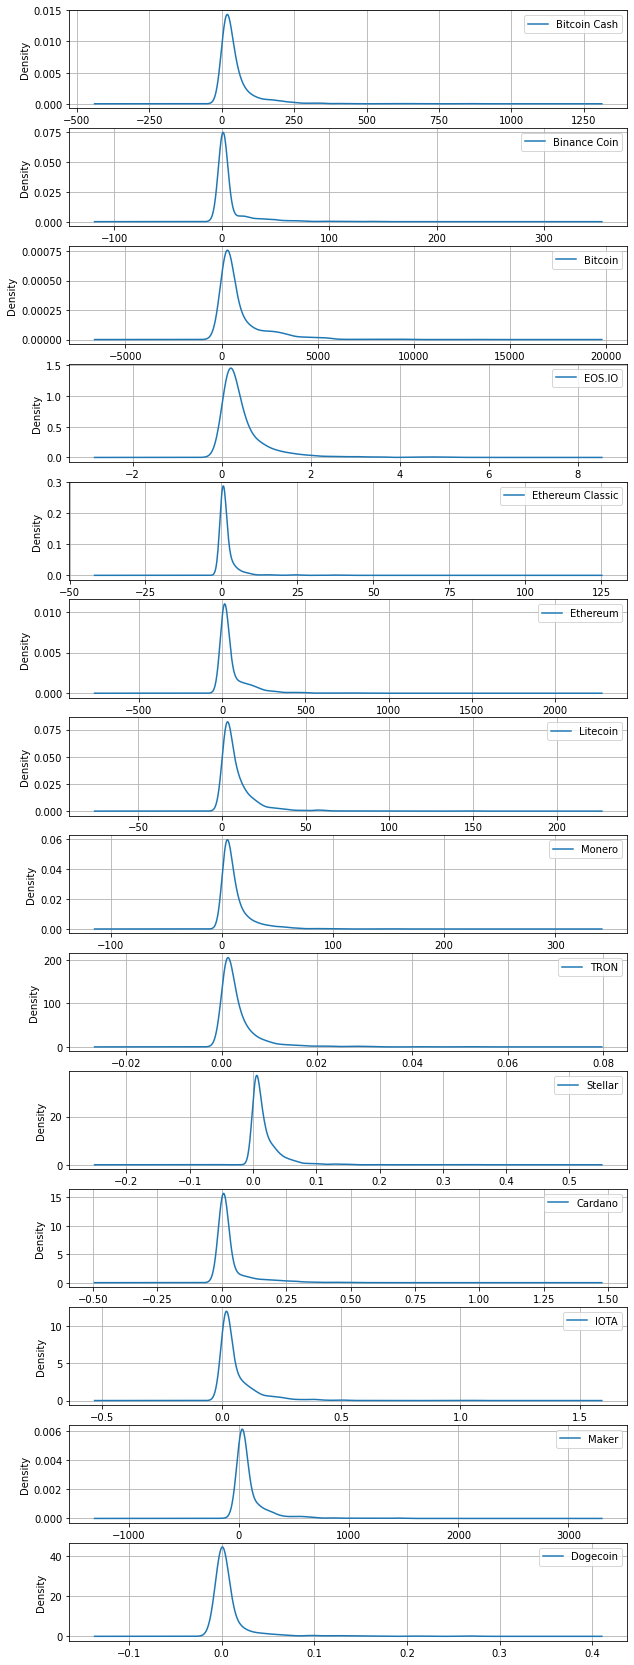

In [25]:
fig, ax = plt.subplots(nrows=14, ncols=1)
#ax = plt.axes()
count = 0

for asset in assets:
    
    grouped_df[grouped_df['Asset_Name'] == asset]['diff_val'].plot.density(figsize = (10, 30),
                       linewidth = 1.5, ax = ax[count], label = asset)
    ax[count].legend()
    ax[count].grid()
    count = count + 1


In [ ]:
#To save memory
del(df_grouped_df)
del(fig, ax)

##### Interpretation of the above charts:
* For Bitcoin, the Daywise average difference between Close and Open has more weight towards the the positive scale and reaches as far as the value +20,000. On the negative side of the scale, it has picked up values even lower than -5000. This range is higher than any other asset.
* Ethereum Classic and Maker also show highe range of difference values and have considerable amount of skew towards the positive differences.

#### Distribution of number of trades

If the count column represents the trades made in a minute then let's look at the distribution of number of trades made on daily basis for all 14 cryptoassets.

In [171]:
grouped_df = df.groupby(['Asset_Name', 'date'], as_index = False).agg({'Count': ['sum']})

In [28]:
grouped_df.head()

,Asset_Name,date,Count
,,,sum
0,Binance Coin,2018-01-01,18200.0
1,Binance Coin,2018-01-02,29923.0
2,Binance Coin,2018-01-03,24572.0
3,Binance Coin,2018-01-04,26176.0
4,Binance Coin,2018-01-05,44906.0


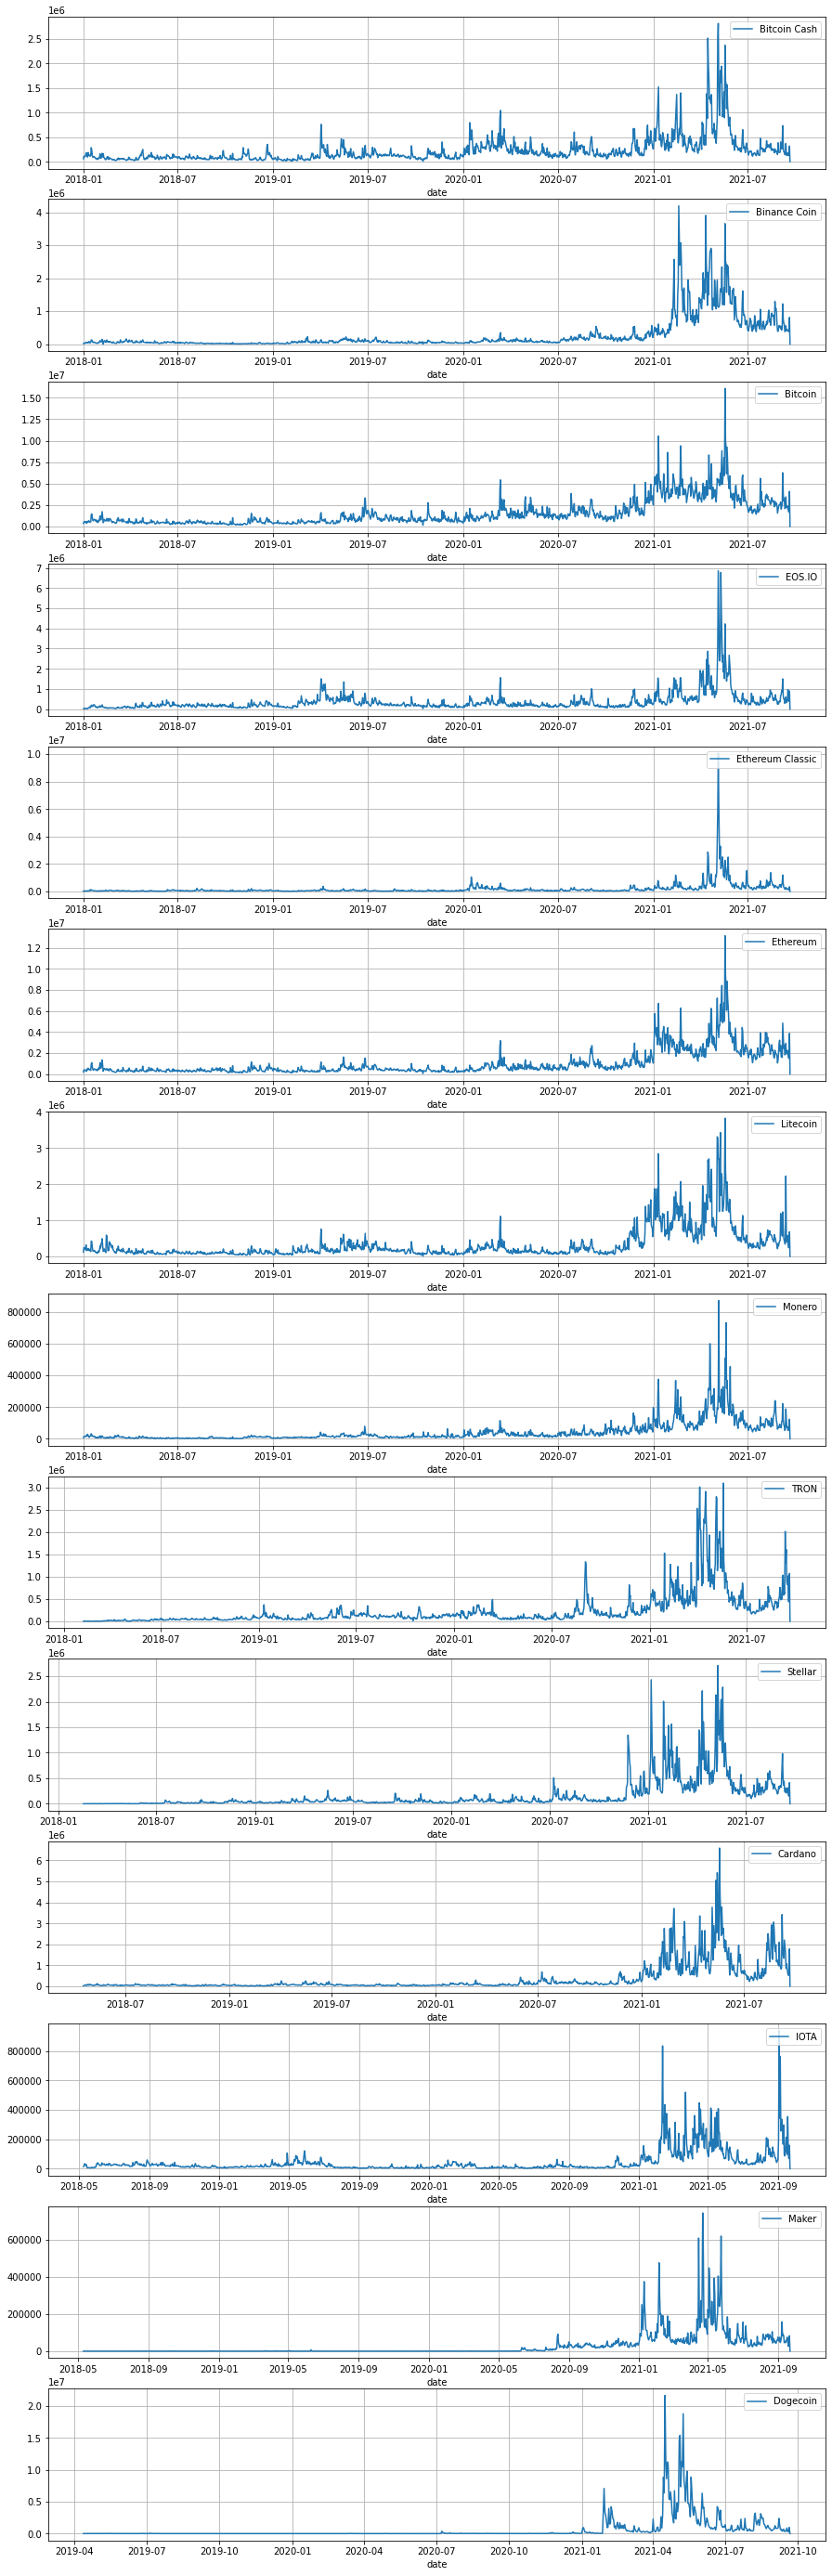

In [29]:
fig, ax = plt.subplots(nrows=14, ncols=1)

count = 0

for asset in assets:
    
    grouped_df[grouped_df['Asset_Name'] == asset].plot(x = 'date', y = ('Count', 'sum'), figsize = (15, 50),
                                                      linewidth = 1.5, ax = ax[count], label = asset)
    
    ax[count].legend(loc='upper right')
    ax[count].grid()
    count = count + 1
#ax.legend(assets)

Intrepretation:
Number of trades have sharply increased at the beginning of the year 2021 compared to their corresponding levels before. Not only that, for all 14 assets the count of trades decreased in the middle of year 2021 and onwards. It showed be noted that we are talking about similarity in pattern here and not in count. The count varies from asset to asset. Bitcoin, Ethereum, and Ethereum Classic has more trades throughout the time in this set. 

### How Close varies in time for different assets ?

Let's investigate how the closed values varied in time for all 14 cryptocurrencies ?

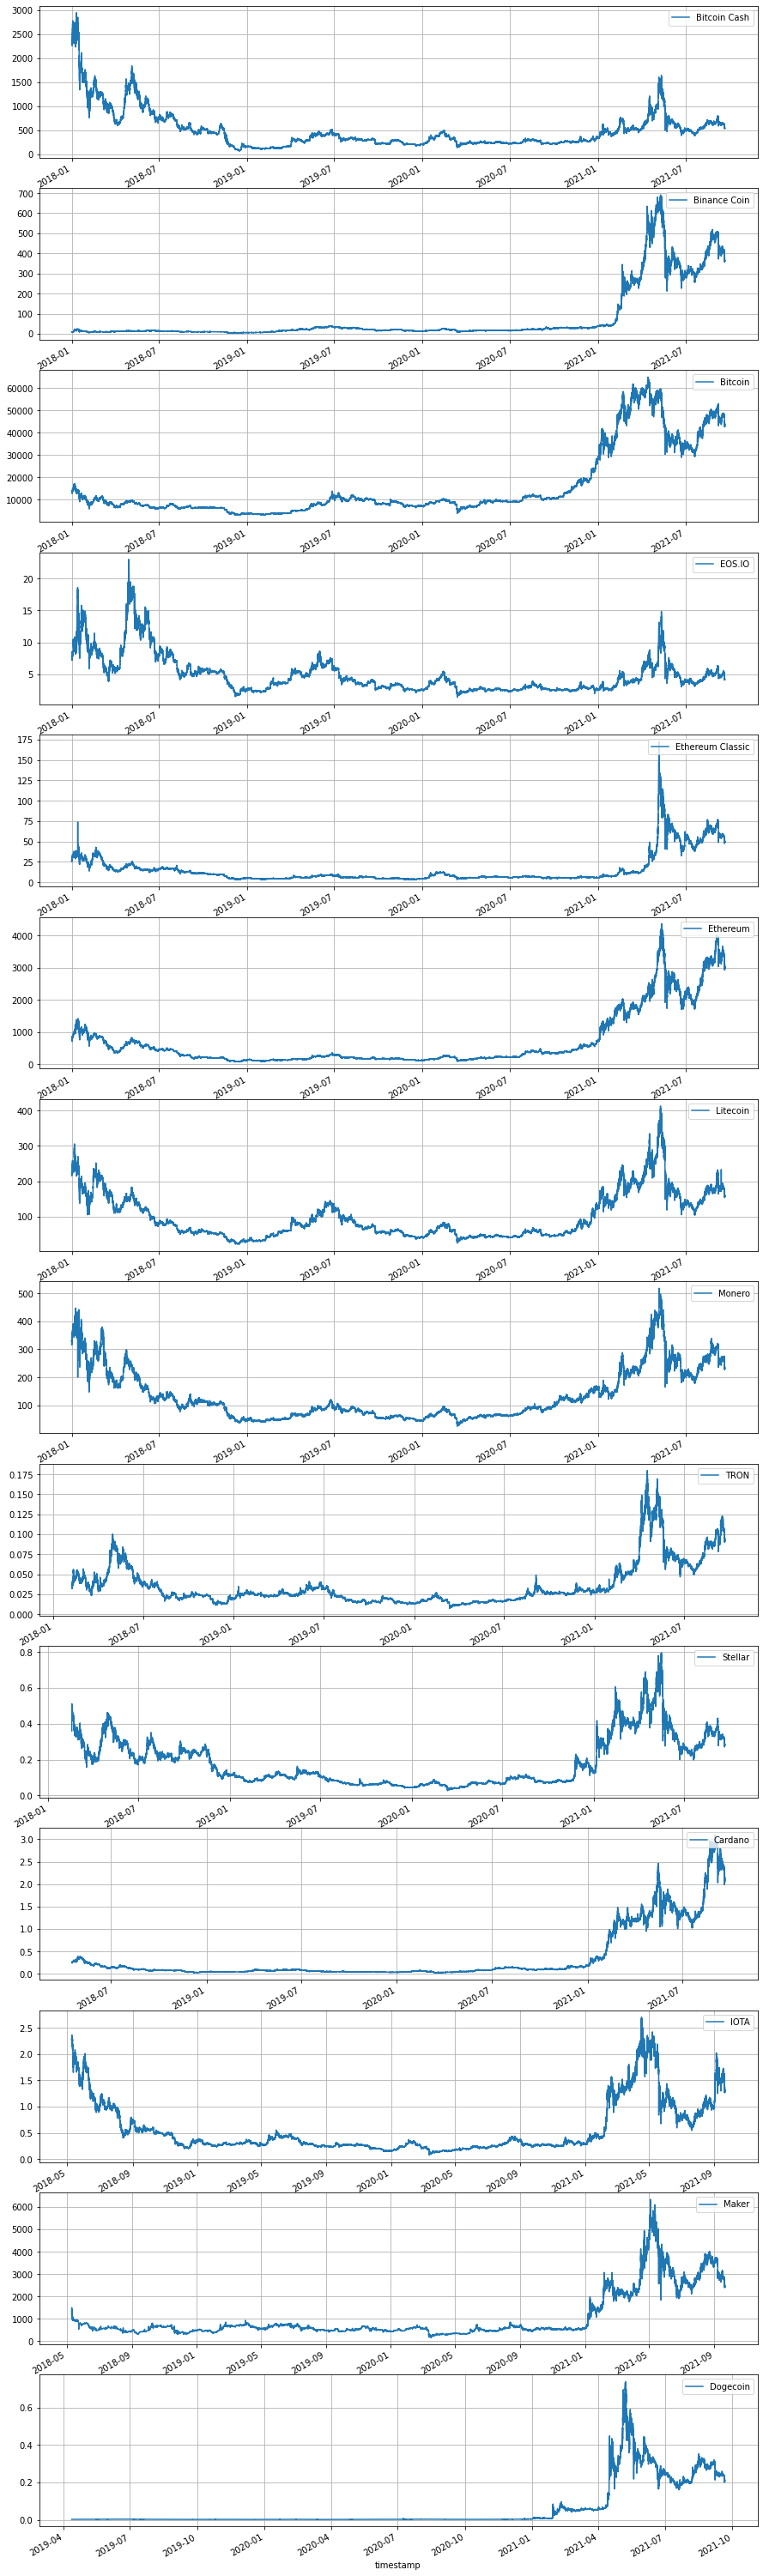

In [30]:
fig, ax = plt.subplots(nrows=14, ncols=1)

count = 0

for asset in assets:
    
    df[df['Asset_Name'] == asset].plot(x = 'timestamp', y = 'Close', figsize = (15, 60),
                                                      linewidth = 1.5, ax = ax[count], label = asset)
    
    ax[count].legend(loc='upper right')
    ax[count].grid()
    count = count + 1

In [ ]:
del(fig, ax)

#### Interpretations:
First, these results are shown regardless of what the opening value was !
Next, notice the similarity in patterns on how the Close values for the all the assets have increased in the beginning of the year 2021 and then abated in the middle of the year. This is in line with the number of trades made for each asset. There is a strong correlation then (*we haven't looked at it yet but we should quantify the correlation !*)

####  Log returns for different assets

In [172]:
# This is the function to define compute log returns as shared in the Tutorial notebook !
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

In [24]:
# removing asset_ID as index
df.reset_index(inplace = True)

In [25]:
# setting timestamp as my new index
df.set_index('timestamp', inplace=True)

In [26]:
# Here we go !
df.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name,Diff,date
timestamp,,,,,,,,,,,,
2018-01-01 00:01:00,0,5.0,8.5300,8.5300,8.5300,8.5300,78.38,8.530000,-0.014399,Binance Coin,0.0000,2018-01-01
2018-01-01 00:02:00,0,7.0,8.5300,8.5300,8.5145,8.5145,71.39,8.520215,-0.015875,Binance Coin,-0.0155,2018-01-01
2018-01-01 00:03:00,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.82,8.501394,-0.015410,Binance Coin,-0.0217,2018-01-01
2018-01-01 00:04:00,0,14.0,8.5009,8.5066,8.4744,8.5009,125.80,8.479810,-0.012524,Binance Coin,0.0000,2018-01-01
2018-01-01 00:05:00,0,5.0,8.5007,8.5007,8.4560,8.4560,125.01,8.458435,-0.005940,Binance Coin,-0.0447,2018-01-01


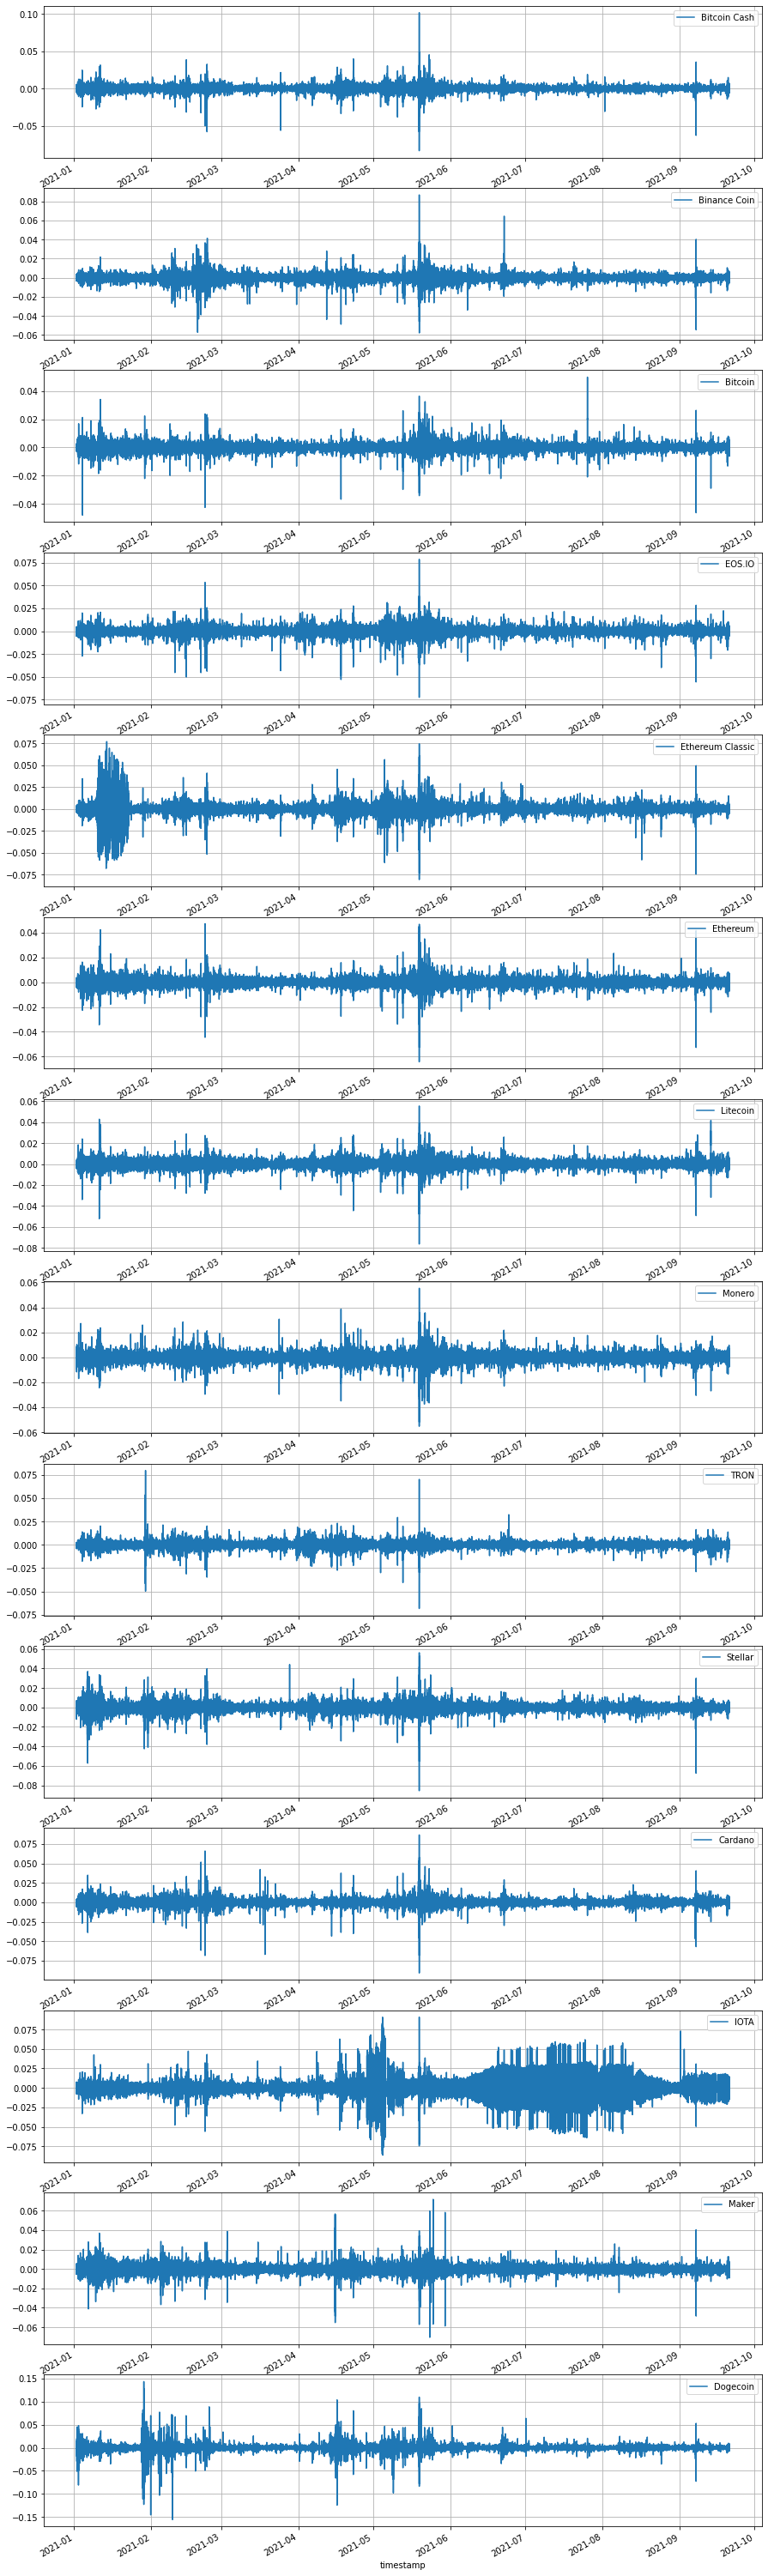

In [32]:
fig, ax = plt.subplots(nrows=14, ncols=1)

count = 0

for asset in assets:
    
    sample_df = df[(df['date']>datetime.date(2021,1,1)) & (df['Asset_Name'] == asset)]
    log_sample = log_return(sample_df.Close)[1:]
    log_sample.plot(figsize = (15, 60), linewidth = 1.5, ax = ax[count], label = asset)
    
    ax[count].legend(loc='upper right')
    ax[count].grid()
    count = count + 1
    del(sample_df)

#### Interpretation:
The above charts show the log returns for all 14 assets, centered and fluctuating around zero all of them, across the entire time (*makes sense!*). We should have a probability distribution plot for this as well !!! might have helped more.

#### Correlation between Cryptocurrencies:
We first compute the correlation between all the assets for the samples of trade or minutes after Jan 1, 2021.

In [77]:
# create dataframe with returns for the above assets
assets_samples = pd.DataFrame([])

for i in range(0, len(assets)):
    
    asset_name = assets[i]
    df_1 = df[(df['date']>datetime.date(2021,1,1)) & (df['Asset_Name'] == asset_name)]
    lret_df = log_return(df_1.Close.fillna(0))[1:]
    lret_df.rename(asset_name)
    
    assets_samples = assets_samples.join(lret_df, rsuffix=asset_name, how = 'outer')
    
    del(df_1)
    del(lret_df)
    

In [78]:
assets_samples.columns = assets
assets_samples.head()

,Bitcoin Cash,Binance Coin,Bitcoin,EOS.IO,Ethereum Classic,Ethereum,Litecoin,Monero,TRON,Stellar,Cardano,IOTA,Maker,Dogecoin
timestamp,,,,,,,,,,,,,,
2021-01-02 00:01:00,-0.001800,-0.002426,-0.001186,-0.001799,-0.001072,-0.001134,-0.001579,-0.005632,-0.000236,-0.001108,-0.001083,0.000344,-0.001360,-0.004352
2021-01-02 00:02:00,-0.003680,-0.000269,0.000114,-0.000342,-0.000015,-0.001431,-0.002531,-0.009277,-0.000273,-0.001659,-0.001855,-0.001032,-0.000539,0.003435
2021-01-02 00:03:00,-0.000241,-0.000145,-0.000427,-0.000920,-0.000978,-0.000985,-0.001062,0.002585,-0.000087,-0.001580,-0.000422,-0.001205,-0.001239,0.001774
2021-01-02 00:04:00,-0.003041,-0.001702,-0.001271,-0.003744,-0.000859,-0.002545,-0.002363,-0.008396,0.000588,-0.003315,-0.003979,-0.003970,-0.003204,-0.003061
2021-01-02 00:05:00,0.000167,-0.000593,0.000630,-0.001407,-0.000018,0.000665,-0.000266,0.000207,-0.000626,0.000415,0.000079,0.000000,-0.000800,0.003715


In [86]:
corr = assets_samples.corr()
corr.style.background_gradient(cmap='coolwarm')

,Bitcoin Cash,Binance Coin,Bitcoin,EOS.IO,Ethereum Classic,Ethereum,Litecoin,Monero,TRON,Stellar,Cardano,IOTA,Maker,Dogecoin
Bitcoin Cash,1.000000,0.619407,0.699565,0.714907,0.402946,0.720911,0.755023,0.601349,0.604190,0.589866,0.607218,0.206682,0.521378,0.353263
Binance Coin,0.619407,1.000000,0.669879,0.613233,0.362199,0.678336,0.646617,0.566001,0.551885,0.547952,0.617032,0.207070,0.501358,0.339388
Bitcoin,0.699565,0.669879,1.000000,0.651836,0.385805,0.824933,0.753901,0.622431,0.592148,0.599028,0.650977,0.216484,0.546425,0.396089
EOS.IO,0.714907,0.613233,0.651836,1.000000,0.402387,0.676535,0.699410,0.580396,0.619135,0.593123,0.604395,0.206205,0.500751,0.346337
Ethereum Classic,0.402946,0.362199,0.385805,0.402387,1.000000,0.404305,0.399659,0.346415,0.346428,0.340057,0.354789,0.121424,0.303401,0.208837
Ethereum,0.720911,0.678336,0.824933,0.676535,0.404305,1.000000,0.764017,0.626505,0.604245,0.613344,0.665785,0.220259,0.577819,0.386075
Litecoin,0.755023,0.646617,0.753901,0.699410,0.399659,0.764017,1.000000,0.613215,0.609145,0.605790,0.645100,0.212718,0.537731,0.365000
Monero,0.601349,0.566001,0.622431,0.580396,0.346415,0.626505,0.613215,1.000000,0.521472,0.533047,0.561618,0.196446,0.492556,0.309952
TRON,0.604190,0.551885,0.592148,0.619135,0.346428,0.604245,0.609145,0.521472,1.000000,0.533936,0.551735,0.188287,0.472811,0.318519
Stellar,0.589866,0.547952,0.599028,0.593123,0.340057,0.613344,0.605790,0.533047,0.533936,1.000000,0.609932,0.192199,0.473513,0.312759


As stated above, these correlation numbers are computed over a sample of time series data after the date Jan 1, 2021. However, in such a dataset, correlation between the columns / assets can vary in time.
Let us check the consistency in correlation in time for the assets that have high correlation between them. We set the threshold of 0.75 and shortlist the pairs that have correlation number higher than this.

* Bitcoin Cash - Litecoin
* Bitcoin - Litecoin
* Bitcoin - Ethereum
* Ethereum - Litecoin

In [87]:
pairs_assets = [('Bitcoin Cash', 'Litecoin'), ('Bitcoin', 'Litecoin'), ('Bitcoin', 'Ethereum'), ('Ethereum', 'Litecoin')]

In [88]:
print(pairs_assets)

[('Bitcoin Cash', 'Litecoin'), ('Bitcoin', 'Litecoin'), ('Bitcoin', 'Ethereum'), ('Ethereum', 'Litecoin')]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


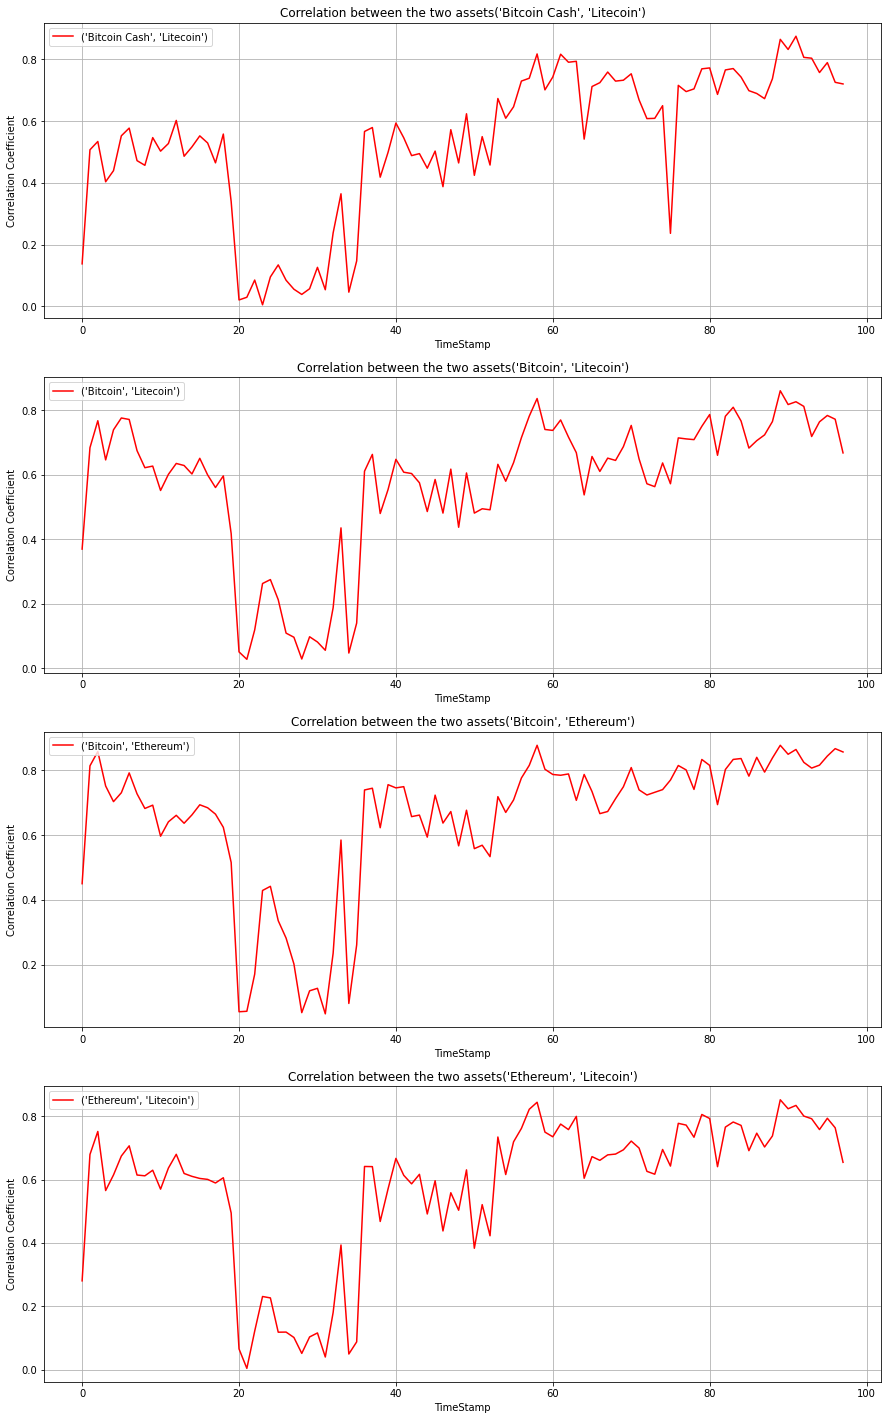

In [170]:
good_pairs = len(pairs_assets)

fig, ax = plt.subplots(nrows=good_pairs, ncols=1)

count = 0

for i in range(good_pairs):
    df_1 = df[df['Asset_Name'] == pairs_assets[i][0]]
    lret_df_1 = log_return(df_1.Close)[1:]
    lret_df_1.rename('lret_df_1', inplace=True)
    
    df_2 = df[df['Asset_Name'] == pairs_assets[i][1]]
    lret_df_2 = log_return(df_2.Close)[1:]
    lret_df_2.rename('lret_df_2', inplace=True)
    
    two_assets = pd.concat([lret_df_1, lret_df_2], axis=1)
    two_assets.reset_index(inplace = True)
    
    two_assets['timestamp'] = two_assets.timestamp.astype('int64') // 10**9
    two_assets.set_index('timestamp')
    
    # group consecutive rows and use .corr() for correlation between columns
    corr_time = two_assets.groupby(two_assets.index//(1000*20)).corr().loc[:,"lret_df_1"].loc[:,"lret_df_2"]

    #corr_time.plot()
    corr_time.plot(figsize = (15, 25), linewidth = 1.5, ax = ax[count], label = str(pairs_assets[i]), color = 'r')
    ax[count].legend(loc='upper left')
    ax[count].set_xlabel('TimeStamp')
    ax[count].set_ylabel("Correlation Coefficient")
    ax[count].set_title("Correlation between the two assets"+str(pairs_assets[i]))
    ax[count].grid()
    
    count = count + 1
    
    del(df_1)
    del(df_2)
    del(lret_df_1)
    del(lret_df_2)
    del(two_assets)
    del(corr_time)

Interestingly ! They have different correlation numbers in time but they have a very similar pattern. We can:
* Make finer the granularity level by wich the timestamps are grouped and check to what extent it holds.
* Decrease the threshold on the correlation computed on the latest sample to include more pairs in the list and see how the pattern varies.
* In the time window where these assets-pairs have low correlations, which other assets show higher correlation to these assets.